Starting the project with importing necessary libraries

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split,StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifier, Perceptron
from sklearn.svm import SVC
from sklearn.metrics import f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import CategoricalNB, GaussianNB
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

Importing the dataset:

In [3]:
train_data = pd.read_csv("/kaggle/input/System-Threat-Forecaster/train.csv")
test_data = pd.read_csv("/kaggle/input/System-Threat-Forecaster/test.csv")

Finding out the dimensions of the train data

In [4]:
train_data.shape

(100000, 76)

Using dummy classifier for the first submission

In [5]:
# random_targets = np.random.randint(0, 2, size=len(test_data))

# submission = pd.DataFrame({
#     "id": range(len(test_data)),
#     "target": random_targets
# })

# submission.to_csv("submission.csv", index=False)
# print("Random dummy classification saved to submission.csv")


Taking a first look at the data using the head() method:

In [6]:
train_data.head()

,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,NumAntivirusProductsEnabled,HasTpm,CountryID,CityID,GeoRegionID,LocaleEnglishNameID,PlatformType,Processor,OSVersion,OSBuildNumber,OSProductSuite,OsPlatformSubRelease,OSBuildLab,SKUEditionName,IsSystemProtected,AutoSampleSubmissionEnabled,SMode,IEVersionID,FirewallEnabled,EnableLUA,MDC2FormFactor,DeviceFamily,OEMNameID,OEMModelID,ProcessorCoreCount,ProcessorManufacturerID,ProcessorModelID,PrimaryDiskCapacityMB,PrimaryDiskType,SystemVolumeCapacityMB,HasOpticalDiskDrive,TotalPhysicalRAMMB,ChassisType,PrimaryDisplayDiagonalInches,PrimaryDisplayResolutionHorizontal,PrimaryDisplayResolutionVertical,PowerPlatformRole,InternalBatteryNumberOfCharges,NumericOSVersion,OSArchitecture,OSBranch,OSBuildNumberOnly,OSBuildRevisionOnly,OSEdition,OSSkuFriendlyName,OSInstallType,OSInstallLanguageID,OSUILocaleID,AutoUpdateOptionsName,IsPortableOS,OSGenuineState,LicenseActivationChannel,IsFlightsDisabled,FlightRing,FirmwareManufacturerID,FirmwareVersionID,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,DateAS,DateOS,target
0,f541bae429089117c4aac39c90dd3416,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1003.0,0,7.0,0,53447.0,1.0,1.0,1,51,120232.0,98.0,103,windows10,x86,10.0.0.0,14393,768,rs1,14393.2214.x86fre.rs1_release_1.180402-1758,Home,1.0,0,0.0,98.0,1.0,1.0,SmallTablet,Windows.Desktop,561.0,330367.0,4.0,5.0,1850.0,15028.0,SSD,14348.0,0,1024.0,Notebook,8.0,800.0,1280.0,Slate,1.420000e+02,10.0.14393.2214,x86,rs1_release,14393,2214,Core,CORE,Update,5.0,26,UNKNOWN,0,IS_GENUINE,Retail,0.0,Retail,513.0,21964.0,0,0.0,1,0,1.0,0.0,6.0,2018-09-10 10:11:00,2018-04-17,0
1,dc2b14d9ce3a0ce4050bb640190f2ca5,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1465.0,0,7.0,0,53447.0,1.0,1.0,1,141,112854.0,167.0,227,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,0.0,137.0,1.0,1.0,AllInOne,Windows.Desktop,2668.0,25212.0,4.0,5.0,2407.0,953869.0,HDD,952592.0,1,4096.0,AllinOne,19.4,1600.0,900.0,Desktop,4.294967e+09,10.0.17134.228,amd64,rs4_release,17134,228,Professional,PROFESSIONAL,UUPUpgrade,9.0,34,FullAuto,0,IS_GENUINE,OEM:DM,0.0,Retail,628.0,44548.0,1,0.0,0,0,0.0,0.0,10.0,2018-08-16 00:01:00,2018-08-14,1
2,fd20c5f010e9c5f91ad1c6b3e0da68a0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1546.0,0,7.0,0,53447.0,1.0,1.0,1,51,41759.0,98.0,103,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,0.0,137.0,1.0,1.0,Desktop,Windows.Desktop,3035.0,263666.0,4.0,5.0,2719.0,228936.0,SSD,228321.0,1,8192.0,Desktop,24.0,1920.0,1080.0,Desktop,4.294967e+09,10.0.17134.285,amd64,rs4_release,17134,285,Core,CORE,Reset,5.0,26,FullAuto,0,IS_GENUINE,OEM:NONSLP,0.0,Retail,142.0,9414.0,0,0.0,0,0,0.0,1.0,6.0,2018-09-20 23:20:00,2018-09-11,1
3,38711eae85eb77a72ec5dfdf27eb2a76,win8defender,1.1.15200.1,4.12.17007.18011,1.275.1141.0,0,7.0,0,46413.0,2.0,1.0,1,68,19507.0,276.0,74,windows10,x64,10.0.0.0,15063,768,rs2,15063.0.amd64fre.rs2_release.170317-1834,Home,1.0,0,0.0,108.0,1.0,1.0,Notebook,Windows.Desktop,2102.0,242491.0,4.0,5.0,3410.0,1907729.0,HDD,1890776.0,0,8192.0,Notebook,15.5,1366.0,768.0,Mobile,0.000000e+00,10.0.15063.850,amd64,rs2_release,15063,850,Core,CORE,Upgrade,7.0,30,UNKNOWN,0,IS_GENUINE,OEM:DM,0.0,Retail,554.0,33060.0,1,0.0,0,0,0.0,0.0,12.0,2018-09-14 00:32:00,2018-01-03,1
4,32607c9a543a9214e2c7e45800ed4849,win8defender,1.1.15200.1,4.13.17134.228,1.275.1283.0,0,7.0,0,40466.0,2.0,1.0,1,43,117801.0,53.0,42,windows10,x86,10.0.0.0,17134,256,rs4,17134.1.x86fre.rs4_release.180410-1804,Pro,1.0,0,0.0,137.0,1.0,1.0,Desktop,Windows.Desktop,2668.0,257309.0,2.0,5.0,4322.0,305245.0,HDD,52804.0,0,2048.0,Desktop,20.0,1600.0,900.0,Desktop,4.294967e+09,10.0.17134.285,x86,rs4_release,17134,285,Professional,PROFESSIONAL,UUPUpgrade,37.0,158,FullAuto,0,IS_GENUINE,Retail,0.0,Retail,628.0

Next, we can get a list of features in the dataset along with the label

In [8]:
feature_list = train_data.columns[:-1].values
label = [train_data.columns[-1]]

print("Feature List:", feature_list)
print("Label:", label)

Feature List: ['MachineID' 'ProductName' 'EngineVersion' 'AppVersion' 'SignatureVersion'
 'IsBetaUser' 'RealTimeProtectionState' 'IsPassiveModeEnabled'
 'AntivirusConfigID' 'NumAntivirusProductsInstalled'
 'NumAntivirusProductsEnabled' 'HasTpm' 'CountryID' 'CityID' 'GeoRegionID'
 'LocaleEnglishNameID' 'PlatformType' 'Processor' 'OSVersion'
 'OSBuildNumber' 'OSProductSuite' 'OsPlatformSubRelease' 'OSBuildLab'
 'SKUEditionName' 'IsSystemProtected' 'AutoSampleSubmissionEnabled'
 'SMode' 'IEVersionID' 'FirewallEnabled' 'EnableLUA' 'MDC2FormFactor'
 'DeviceFamily' 'OEMNameID' 'OEMModelID' 'ProcessorCoreCount'
 'ProcessorManufacturerID' 'ProcessorModelID' 'PrimaryDiskCapacityMB'
 'PrimaryDiskType' 'SystemVolumeCapacityMB' 'HasOpticalDiskDrive'
 'TotalPhysicalRAMMB' 'ChassisType' 'PrimaryDisplayDiagonalInches'
 'PrimaryDisplayResolutionHorizontal' 'PrimaryDisplayResolutionVertical'
 'PowerPlatformRole' 'InternalBatteryNumberOfCharges' 'NumericOSVersion'
 'OSArchitecture' 'OSBranch' 'OSBuildNu

In [9]:
categorical_columns = train_data.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns:", categorical_columns)
print(f"There are {len(categorical_columns)} categorical features")

numerical_columns = train_data.select_dtypes(include=['float64','int64']).columns.tolist()
print("Numerical Columns:", numerical_columns)
print(f"There are {len(numerical_columns)} numerical features")

Categorical Columns: ['MachineID', 'ProductName', 'EngineVersion', 'AppVersion', 'SignatureVersion', 'PlatformType', 'Processor', 'OSVersion', 'OsPlatformSubRelease', 'OSBuildLab', 'SKUEditionName', 'MDC2FormFactor', 'DeviceFamily', 'PrimaryDiskType', 'ChassisType', 'PowerPlatformRole', 'NumericOSVersion', 'OSArchitecture', 'OSBranch', 'OSEdition', 'OSSkuFriendlyName', 'OSInstallType', 'AutoUpdateOptionsName', 'OSGenuineState', 'LicenseActivationChannel', 'FlightRing', 'DateAS', 'DateOS']
There are 28 categorical features
Numerical Columns: ['IsBetaUser', 'RealTimeProtectionState', 'IsPassiveModeEnabled', 'AntivirusConfigID', 'NumAntivirusProductsInstalled', 'NumAntivirusProductsEnabled', 'HasTpm', 'CountryID', 'CityID', 'GeoRegionID', 'LocaleEnglishNameID', 'OSBuildNumber', 'OSProductSuite', 'IsSystemProtected', 'AutoSampleSubmissionEnabled', 'SMode', 'IEVersionID', 'FirewallEnabled', 'EnableLUA', 'OEMNameID', 'OEMModelID', 'ProcessorCoreCount', 'ProcessorManufacturerID', 'ProcessorMo

Data Statistics through the info() method can be used to get a quick description of the data

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MachineID                           100000 non-null  object 
 1   ProductName                         100000 non-null  object 
 2   EngineVersion                       100000 non-null  object 
 3   AppVersion                          100000 non-null  object 
 4   SignatureVersion                    100000 non-null  object 
 5   IsBetaUser                          100000 non-null  int64  
 6   RealTimeProtectionState             99934 non-null   float64
 7   IsPassiveModeEnabled                100000 non-null  int64  
 8   AntivirusConfigID                   99924 non-null   float64
 9   NumAntivirusProductsInstalled       99924 non-null   float64
 10  NumAntivirusProductsEnabled         99924 non-null   float64
 11  HasTpm                     

In [11]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 75 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   MachineID                           10000 non-null  object 
 1   ProductName                         10000 non-null  object 
 2   EngineVersion                       10000 non-null  object 
 3   AppVersion                          10000 non-null  object 
 4   SignatureVersion                    10000 non-null  object 
 5   IsBetaUser                          10000 non-null  int64  
 6   RealTimeProtectionState             9991 non-null   float64
 7   IsPassiveModeEnabled                10000 non-null  int64  
 8   AntivirusConfigID                   9998 non-null   float64
 9   NumAntivirusProductsInstalled       9998 non-null   float64
 10  NumAntivirusProductsEnabled         9998 non-null   float64
 11  HasTpm                              10000 

The first inference from this information is that there are 31 float features, 16 integer features and 28 categorical features in the dataset. So we can make two lists, one for the features with categorical data and the other for features with numerical data. Note that we will do this for the test dataset so that we do not include the target column.

Next, we can check exactly how many missing values exist in the datasets

In [12]:
print("\nMissing Values in Train Data:")
print(train_data.isnull().sum().sort_values(ascending=False))

print("\nMissing Values in Test Data:")
print(test_data.isnull().sum().sort_values(ascending=False))


Missing Values in Train Data:
SMode                                 981
CityID                                623
RegionIdentifier                      559
IsGamer                               559
InternalBatteryNumberOfCharges        515
FirmwareManufacturerID                376
FirmwareVersionID                     334
IsFlightsDisabled                     326
OEMModelID                            228
OEMNameID                             212
FirewallEnabled                       166
TotalPhysicalRAMMB                    151
IsAlwaysOnAlwaysConnectedCapable      134
OSInstallLanguageID                   113
PrimaryDiskCapacityMB                 110
SystemVolumeCapacityMB                110
IEVersionID                           107
ProcessorManufacturerID                85
ProcessorModelID                       85
ProcessorCoreCount                     85
IsSystemProtected                      76
NumAntivirusProductsEnabled            76
NumAntivirusProductsInstalled          76
Ant

In order to understand the nature of the numeric attributes, we will use the describe() method

In [13]:
train_data.describe(include='all')

,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,NumAntivirusProductsEnabled,HasTpm,CountryID,CityID,GeoRegionID,LocaleEnglishNameID,PlatformType,Processor,OSVersion,OSBuildNumber,OSProductSuite,OsPlatformSubRelease,OSBuildLab,SKUEditionName,IsSystemProtected,AutoSampleSubmissionEnabled,SMode,IEVersionID,FirewallEnabled,EnableLUA,MDC2FormFactor,DeviceFamily,OEMNameID,OEMModelID,ProcessorCoreCount,ProcessorManufacturerID,ProcessorModelID,PrimaryDiskCapacityMB,PrimaryDiskType,SystemVolumeCapacityMB,HasOpticalDiskDrive,TotalPhysicalRAMMB,ChassisType,PrimaryDisplayDiagonalInches,PrimaryDisplayResolutionHorizontal,PrimaryDisplayResolutionVertical,PowerPlatformRole,InternalBatteryNumberOfCharges,NumericOSVersion,OSArchitecture,OSBranch,OSBuildNumberOnly,OSBuildRevisionOnly,OSEdition,OSSkuFriendlyName,OSInstallType,OSInstallLanguageID,OSUILocaleID,AutoUpdateOptionsName,IsPortableOS,OSGenuineState,LicenseActivationChannel,IsFlightsDisabled,FlightRing,FirmwareManufacturerID,FirmwareVersionID,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,DateAS,DateOS,target
count,100000,100000,100000,100000,100000,100000.0,99934.000000,100000.000000,99924.000000,99924.000000,99924.000000,100000.000000,100000.000000,99377.000000,100000.000000,100000.000000,100000,100000,100000,100000.000000,100000.000000,100000,100000,100000,99924.000000,100000.0,99019.000000,99893.000000,99834.000000,99981.000000,100000,100000,99788.000000,99772.000000,99915.000000,99915.000000,99915.000000,9.989000e+04,99977,9.989000e+04,100000.00000,99849.000000,99998,99928.000000,99928.000000,99928.000000,100000,9.948500e+04,100000,100000,100000,100000.000000,100000.000000,100000,100000,100000,99887.000000,100000.000000,100000,100000.000000,100000,100000,99674.0,100000,99624.000000,99666.000000,100000.000000,99980.000000,100000.000000,100000.000000,99866.000000,99441.000000,99441.000000,100000,99976,100000.000000
unique,99835,2,37,69,2735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,3,7,NaN,NaN,9,281,8,NaN,NaN,NaN,NaN,NaN,NaN,11,2,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,28,NaN,NaN,NaN,9,NaN,221,3,13,NaN,NaN,20,18,9,NaN,NaN,6,NaN,4,6,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2695,112,NaN
top,8e0523438a5ca48323f50b2c47f6d31a,win8defender,1.1.15200.1,4.18.1807.18075,1.273.1420.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,windows10,x64,10.0.0.0,NaN,NaN,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,NaN,NaN,NaN,NaN,NaN,NaN,Notebook,Windows.Desktop,NaN,NaN,NaN,NaN,NaN,NaN,HDD,NaN,NaN,NaN,Notebook,NaN,NaN,NaN,Mobile,NaN,10.0.17134.228,amd64,rs4_release,NaN,NaN,Core,CORE,UUPUpgrade,NaN,NaN,FullAuto,NaN,IS_GENUINE,Retail,NaN,Retail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-08-15 06:29:00,2018-08-14,NaN
freq,2,99771,45219,62119,1274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98344,91262,98368,NaN,NaN,45837,42964,62863,NaN,NaN,NaN,NaN,NaN,NaN,64547,99971,NaN,NaN,NaN,NaN,NaN,NaN,66202,NaN,NaN,NaN,59459,NaN,NaN,NaN,69874,NaN,17069,91281,46909,NaN,NaN,39275,39273,32033,NaN,NaN,45154,NaN,89860,52195,NaN,94153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1274,20905,NaN
mean,NaN,NaN,NaN,NaN,NaN,0.0,6.848430,0.017620,47975.710440,1.326528,1.018264,0.996780,108.078790,81029.938587,169.741630,122.695100,NaN,NaN,NaN,15917.208720,578.403380,NaN,NaN,NaN,0.955326,0.0,0.000505,124.053848,0.980067,0.996569,NaN,NaN,2209.573265,238780.914154,4.011500,4.530711,2367.693069,5.158619e+05,NaN,3.819905e+05,0.08140,6132.087442,NaN,16.708674,1552.230416,898.253192,NaN,1.118069e+09,NaN,NaN,NaN,15990.596350,986.531360,NaN,NaN,NaN,14.519267,60.030870,NaN,0.000520,NaN,NaN,0.0,NaN,401.987613,32942.648044,0.495690,0.003841,0.128470,0.040580,0.058398,0.296668,7.875866,NaN,NaN,0.505250
std,NaN,NaN,NaN,NaN,NaN,0.0,1.015166,0.131566,13803.321533,0.520681,0.155291,0.056654,63.062151,48944.027074,89.188929,69.242252,NaN,NaN,NaN,1943.421132,247

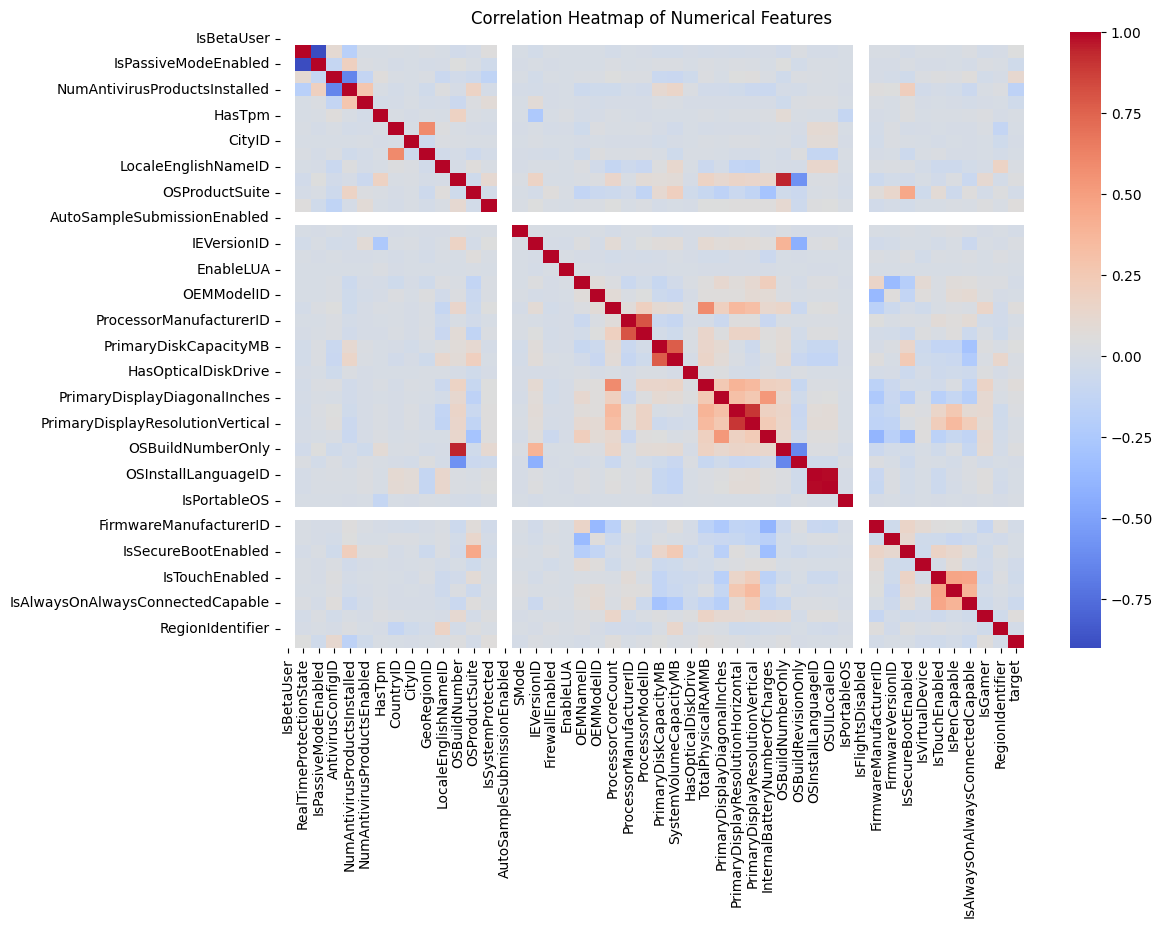

In [14]:
numerical_columns = train_data.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(12, 8))
sns.heatmap(train_data[numerical_columns].corr(), annot=False, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

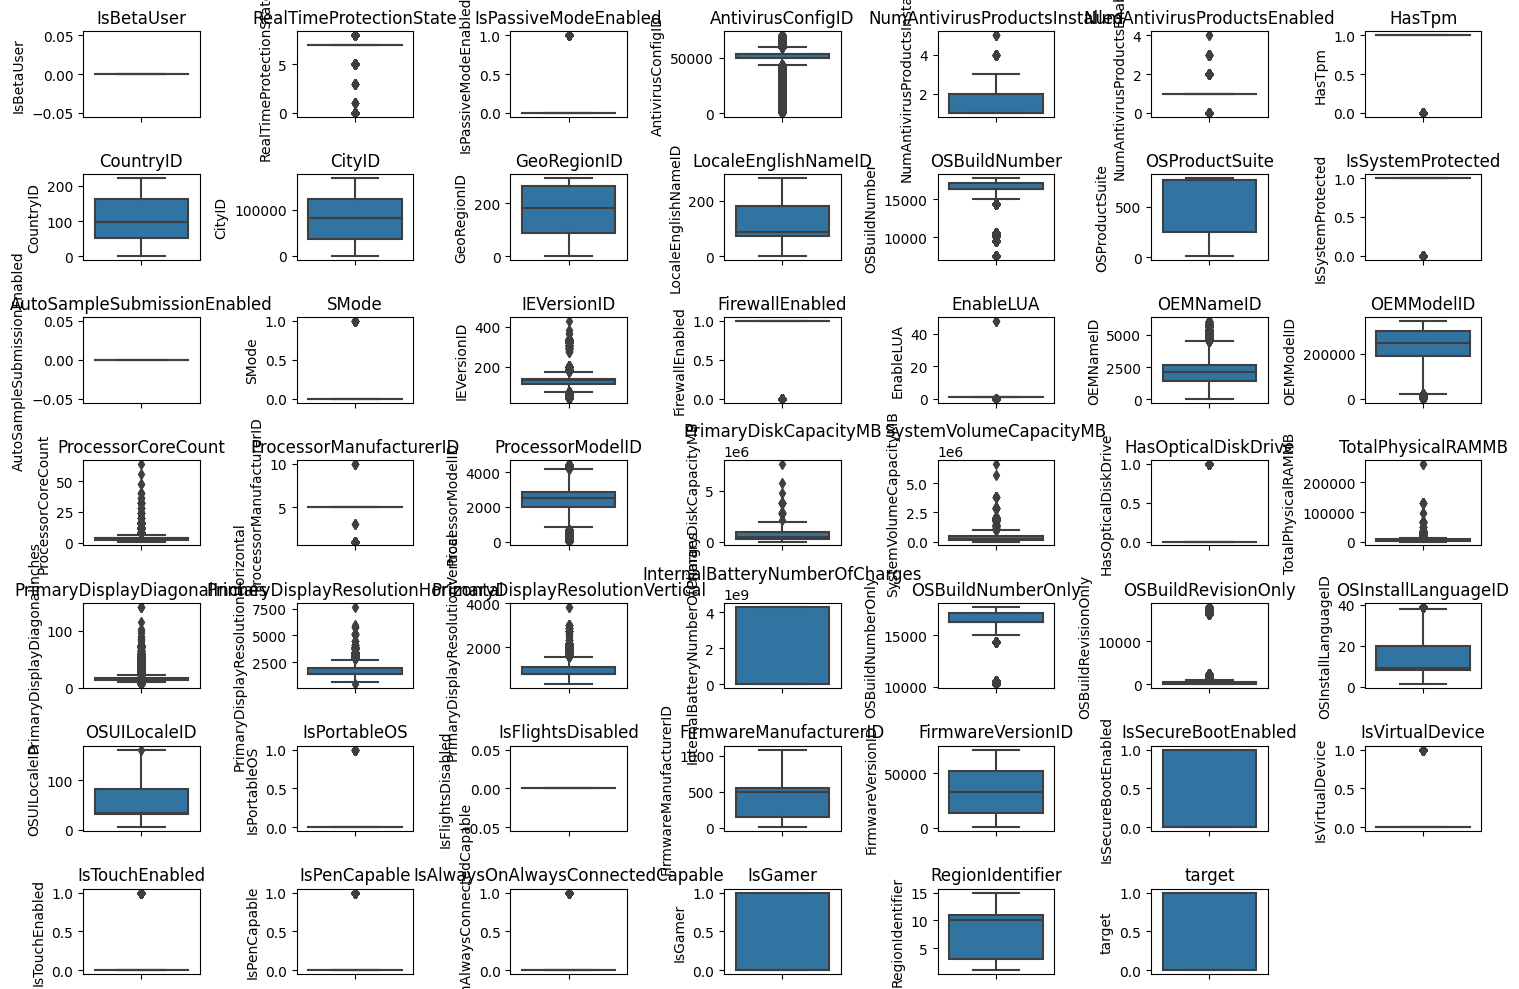

In [17]:
num_cols = len(numerical_columns)
rows = math.ceil(math.sqrt(num_cols))
cols = math.ceil(num_cols / rows)

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(y=train_data[col])
    plt.title(col)

plt.tight_layout()
plt.show()

In [18]:
def count_outliers_iqr(df, numerical_columns):
    outlier_counts = {}
    
    for col in numerical_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_counts[col] = outliers.shape[0]

    return outlier_counts

outlier_counts = count_outliers_iqr(train_data, numerical_columns)
for col, count in outlier_counts.items():
    print(f"{col}: {count} outliers")

IsBetaUser: 0 outliers
RealTimeProtectionState: 2559 outliers
IsPassiveModeEnabled: 1762 outliers
AntivirusConfigID: 19581 outliers
NumAntivirusProductsInstalled: 96 outliers
NumAntivirusProductsEnabled: 2259 outliers
HasTpm: 322 outliers
CountryID: 0 outliers
CityID: 0 outliers
GeoRegionID: 0 outliers
LocaleEnglishNameID: 0 outliers
OSBuildNumber: 15982 outliers
OSProductSuite: 0 outliers
IsSystemProtected: 4464 outliers
AutoSampleSubmissionEnabled: 0 outliers
SMode: 50 outliers
IEVersionID: 4949 outliers
FirewallEnabled: 1990 outliers
EnableLUA: 487 outliers
OEMNameID: 10270 outliers
OEMModelID: 747 outliers
ProcessorCoreCount: 11142 outliers
ProcessorManufacturerID: 11735 outliers
ProcessorModelID: 10931 outliers
PrimaryDiskCapacityMB: 66 outliers
SystemVolumeCapacityMB: 847 outliers
HasOpticalDiskDrive: 8140 outliers
TotalPhysicalRAMMB: 7094 outliers
PrimaryDisplayDiagonalInches: 10749 outliers
PrimaryDisplayResolutionHorizontal: 1035 outliers
PrimaryDisplayResolutionVertical: 1899

In [19]:
def cap_outliers_iqr(df, numerical_columns):
    for col in numerical_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

train_data = cap_outliers_iqr(train_data, numerical_columns)

Instead of dropping the rows with outliers, it was better to cap them to the bounds

We can find the total number of duplicate rows in the dataset.

In [20]:
train_data.duplicated().sum()

165

In [21]:
train_data = train_data.drop_duplicates()

The following are the redundant columns in the dataset that have the same value for all given rows

In [22]:
constant_columns = [col for col in train_data.columns if train_data[col].nunique() == 1]
print(f"Constant columns: {constant_columns}")

Constant columns: ['IsBetaUser', 'RealTimeProtectionState', 'IsPassiveModeEnabled', 'NumAntivirusProductsEnabled', 'HasTpm', 'IsSystemProtected', 'AutoSampleSubmissionEnabled', 'SMode', 'FirewallEnabled', 'EnableLUA', 'ProcessorManufacturerID', 'HasOpticalDiskDrive', 'IsPortableOS', 'IsFlightsDisabled', 'IsVirtualDevice', 'IsTouchEnabled', 'IsPenCapable', 'IsAlwaysOnAlwaysConnectedCapable']


In [23]:
train_data = train_data.drop(columns=constant_columns)

In [24]:
test_data = test_data.drop(columns=constant_columns)

We can also find identical columns in the dataset where the corresponding values in each row is the same

In [25]:
duplicate_columns = []
for col1 in train_data.columns:
    for col2 in train_data.columns:
        if col1 != col2 and col1 not in duplicate_columns:
            if train_data[col1].equals(train_data[col2]):
                duplicate_columns.append(col2)
                print(f"{col2} is identical to {col1}")
print(f"Duplicate columns: {duplicate_columns}")

Duplicate columns: []


In [26]:
categorical_columns = train_data.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns:", categorical_columns)
print(f"There are {len(categorical_columns)} categorical features")

numerical_columns = train_data.select_dtypes(include=['float64','int64']).columns.tolist()
print("Numerical Columns:", numerical_columns)
print(f"There are {len(numerical_columns)} numerical features")

Categorical Columns: ['MachineID', 'ProductName', 'EngineVersion', 'AppVersion', 'SignatureVersion', 'PlatformType', 'Processor', 'OSVersion', 'OsPlatformSubRelease', 'OSBuildLab', 'SKUEditionName', 'MDC2FormFactor', 'DeviceFamily', 'PrimaryDiskType', 'ChassisType', 'PowerPlatformRole', 'NumericOSVersion', 'OSArchitecture', 'OSBranch', 'OSEdition', 'OSSkuFriendlyName', 'OSInstallType', 'AutoUpdateOptionsName', 'OSGenuineState', 'LicenseActivationChannel', 'FlightRing', 'DateAS', 'DateOS']
There are 28 categorical features
Numerical Columns: ['AntivirusConfigID', 'NumAntivirusProductsInstalled', 'CountryID', 'CityID', 'GeoRegionID', 'LocaleEnglishNameID', 'OSBuildNumber', 'OSProductSuite', 'IEVersionID', 'OEMNameID', 'OEMModelID', 'ProcessorCoreCount', 'ProcessorModelID', 'PrimaryDiskCapacityMB', 'SystemVolumeCapacityMB', 'TotalPhysicalRAMMB', 'PrimaryDisplayDiagonalInches', 'PrimaryDisplayResolutionHorizontal', 'PrimaryDisplayResolutionVertical', 'InternalBatteryNumberOfCharges', 'OSBu

In [27]:
correlation_data = train_data[numerical_columns]
correlation_matrix = correlation_data.corr()
correlation_with_target = correlation_matrix['target'].drop('target')

print("Correlation of numerical columns with the target:")
print(correlation_with_target)

Correlation of numerical columns with the target:
AntivirusConfigID                     0.105312
NumAntivirusProductsInstalled        -0.151728
CountryID                             0.004636
CityID                               -0.004334
GeoRegionID                           0.002728
LocaleEnglishNameID                   0.015435
OSBuildNumber                         0.045419
OSProductSuite                       -0.020131
IEVersionID                           0.039981
OEMNameID                            -0.010983
OEMModelID                            0.000825
ProcessorCoreCount                    0.060742
ProcessorModelID                      0.025339
PrimaryDiskCapacityMB                 0.050171
SystemVolumeCapacityMB                0.014289
TotalPhysicalRAMMB                    0.082176
PrimaryDisplayDiagonalInches          0.059613
PrimaryDisplayResolutionHorizontal    0.035054
PrimaryDisplayResolutionVertical      0.015810
InternalBatteryNumberOfCharges        0.017456
OSBuildNum

Ideally, we want to eliminate all such columns that either have the same values for most of the data or have unique values for most of the data. So, we can remove low variance and high unique value columns since they wont make any meaningful contribution to the dataset.

In [28]:
numerical_data = train_data[numerical_columns]
selector = VarianceThreshold(threshold=0.05)
selector.fit(numerical_data)
low_variance_columns = [col for col, var in zip(numerical_data.columns, selector.variances_) if var < 0.05]
print(f"Low variance columns: {low_variance_columns}")

Low variance columns: []


zip function is used to pair the column  names to their corresponding variance values

In [29]:
high_cardinality_columns = [col for col in numerical_columns if train_data[col].nunique() / len(train_data) > 0.8]
print(f"High-cardinality numerical columns: {high_cardinality_columns}")

High-cardinality numerical columns: []


In [30]:
train_data = train_data.drop(columns = low_variance_columns)

In [31]:
train_data = train_data.drop(columns=high_cardinality_columns)

In [32]:
test_data = test_data.drop(columns = low_variance_columns)

In [33]:
test_data = test_data.drop(columns=high_cardinality_columns)

In [34]:
def categorical_variance(col):
    freqs = col.value_counts(normalize=True)
    return 1 - np.sum(freqs**2)

low_variance_categorical = [col for col in categorical_columns if categorical_variance(train_data[col]) < 0.05]
print(f"Low variance categorical columns: {low_variance_categorical}")
train_data = train_data.drop(columns=low_variance_categorical)
test_data = test_data.drop(columns=low_variance_categorical)

Low variance categorical columns: ['ProductName', 'PlatformType', 'OSVersion', 'DeviceFamily']


In [35]:
categorical_columns = train_data.select_dtypes(include=['object']).columns.tolist()
high_cardinality_categorical = [col for col in categorical_columns if train_data[col].nunique() > 0.8 * len(train_data)]
print(f"High cardinality categorical columns: {high_cardinality_categorical}")
train_data = train_data.drop(columns=high_cardinality_categorical)
test_data = test_data.drop(columns=high_cardinality_categorical)

High cardinality categorical columns: ['MachineID']


We can understand the target column better by printing the number of positive and negative cases.

In [36]:
target_counts = train_data['target'].value_counts()
print(target_counts)
print(f"Proportion of each class:\n{target_counts / len(train_data)}")

target
1    50443
0    49392
Name: count, dtype: int64
Proportion of each class:
target
1    0.505264
0    0.494736
Name: count, dtype: float64


Here, we see that the classes are balanced (both are approximately 50%)

For the numerical features, we can make a correlation matrix and plot

Using Pearson Correlation to find out highly correlated numeric values

In [37]:
categorical_columns = train_data.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns:", categorical_columns)
print(f"There are {len(categorical_columns)} categorical features")

numerical_columns = train_data.select_dtypes(include=['float64','int64']).columns.tolist()
print("Numerical Columns:", numerical_columns)
print(f"There are {len(numerical_columns)} numerical features")

Categorical Columns: ['EngineVersion', 'AppVersion', 'SignatureVersion', 'Processor', 'OsPlatformSubRelease', 'OSBuildLab', 'SKUEditionName', 'MDC2FormFactor', 'PrimaryDiskType', 'ChassisType', 'PowerPlatformRole', 'NumericOSVersion', 'OSArchitecture', 'OSBranch', 'OSEdition', 'OSSkuFriendlyName', 'OSInstallType', 'AutoUpdateOptionsName', 'OSGenuineState', 'LicenseActivationChannel', 'FlightRing', 'DateAS', 'DateOS']
There are 23 categorical features
Numerical Columns: ['AntivirusConfigID', 'NumAntivirusProductsInstalled', 'CountryID', 'CityID', 'GeoRegionID', 'LocaleEnglishNameID', 'OSBuildNumber', 'OSProductSuite', 'IEVersionID', 'OEMNameID', 'OEMModelID', 'ProcessorCoreCount', 'ProcessorModelID', 'PrimaryDiskCapacityMB', 'SystemVolumeCapacityMB', 'TotalPhysicalRAMMB', 'PrimaryDisplayDiagonalInches', 'PrimaryDisplayResolutionHorizontal', 'PrimaryDisplayResolutionVertical', 'InternalBatteryNumberOfCharges', 'OSBuildNumberOnly', 'OSBuildRevisionOnly', 'OSInstallLanguageID', 'OSUILocale

In [38]:
correlation_data = train_data[numerical_columns]
correlation_matrix = correlation_data.corr()
high_corr_pairs = [(col1, col2) for col1 in correlation_matrix.columns for col2 in correlation_matrix.columns
                   if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > 0.9]
print("Highly correlated feature pairs:", high_corr_pairs)

Highly correlated feature pairs: [('OSBuildNumber', 'OSBuildNumberOnly'), ('PrimaryDisplayResolutionHorizontal', 'PrimaryDisplayResolutionVertical'), ('PrimaryDisplayResolutionVertical', 'PrimaryDisplayResolutionHorizontal'), ('OSBuildNumberOnly', 'OSBuildNumber'), ('OSInstallLanguageID', 'OSUILocaleID'), ('OSUILocaleID', 'OSInstallLanguageID')]


In [39]:
cols_to_drop = set()
for col1, col2 in high_corr_pairs:
    if col1 not in cols_to_drop and col2 not in cols_to_drop:
        cols_to_drop.add(col2)
print(f"Columns to drop due to high correlation: {cols_to_drop}")
train_data = train_data.drop(columns=cols_to_drop)
test_data = test_data.drop(columns=cols_to_drop)

Columns to drop due to high correlation: {'OSUILocaleID', 'OSBuildNumberOnly', 'PrimaryDisplayResolutionVertical'}


In [40]:
encoded_data = train_data[categorical_columns].apply(lambda col: LabelEncoder().fit_transform(col))
cat_corr_matrix = encoded_data.corr().abs()
upper_triangle_cat = cat_corr_matrix.where(np.triu(np.ones(cat_corr_matrix.shape), k=1).astype(bool))
print("\nHighly correlated categorical feature pairs:")
for col in upper_triangle_cat.columns:
    for row in upper_triangle_cat.index:
        if upper_triangle_cat.loc[row, col] > 0.9:
            print(f"{row} and {col} (correlation: {upper_triangle_cat.loc[row, col]:.2f})")


Highly correlated categorical feature pairs:
Processor and OSArchitecture (correlation: 0.99)
SKUEditionName and OSSkuFriendlyName (correlation: 0.90)
OSEdition and OSSkuFriendlyName (correlation: 1.00)


In [41]:
high_corr_cat_cols = set()
for col in upper_triangle_cat.columns:
    for row in upper_triangle_cat.index:
        if upper_triangle_cat.loc[row, col] > 0.9: 
            if col not in high_corr_cat_cols and row not in high_corr_cat_cols:
                high_corr_cat_cols.add(col)

print(f"\nCategorical columns to drop due to high correlation: {high_corr_cat_cols}")
train_data = train_data.drop(columns=high_corr_cat_cols)
test_data = test_data.drop(columns=high_corr_cat_cols)


Categorical columns to drop due to high correlation: {'OSArchitecture', 'OSSkuFriendlyName'}


In [42]:
# mi_scores = mutual_info_classif(encoded_data, train_data["target"], discrete_features=True)
# mi_df = pd.DataFrame({"Feature": categorical_columns, "MI Score": mi_scores})
# useful_categorical = mi_df[mi_df["MI Score"] > 0.01]["Feature"].tolist()
# print(f"\nUseful categorical features (based on MI > 0.01): {useful_categorical}")

In [43]:
# mi_scores = mutual_info_classif(encoded_data, train_data["target"], discrete_features=True)
# mi_df = pd.DataFrame({"Feature": categorical_columns, "MI Score": mi_scores})
# useful_categorical = mi_df[mi_df["MI Score"] < 0.05]["Feature"].tolist()
# print(f"\nUseful categorical features (based on MI < 0.05): {useful_categorical}")

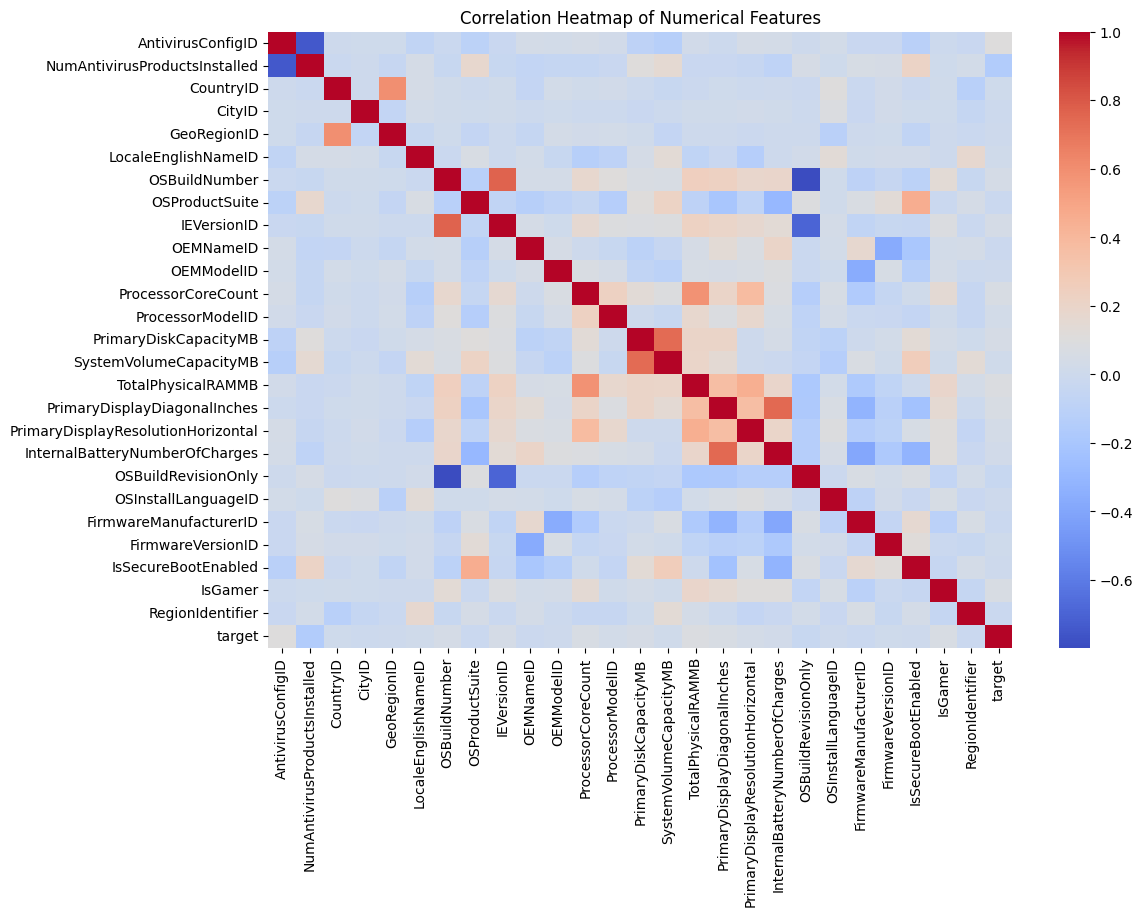

In [44]:
numerical_columns = train_data.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(12, 8))
sns.heatmap(train_data[numerical_columns].corr(), annot=False, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

Final List of categorical and numerical columns

In [45]:
categorical_columns = train_data.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns:", categorical_columns)
print(f"There are {len(categorical_columns)} categorical features")

numerical_columns = train_data.select_dtypes(include=['float64','int64']).columns.tolist()
print("Numerical Columns:", numerical_columns)
print(f"There are {len(numerical_columns)} numerical features")

Categorical Columns: ['EngineVersion', 'AppVersion', 'SignatureVersion', 'Processor', 'OsPlatformSubRelease', 'OSBuildLab', 'SKUEditionName', 'MDC2FormFactor', 'PrimaryDiskType', 'ChassisType', 'PowerPlatformRole', 'NumericOSVersion', 'OSBranch', 'OSEdition', 'OSInstallType', 'AutoUpdateOptionsName', 'OSGenuineState', 'LicenseActivationChannel', 'FlightRing', 'DateAS', 'DateOS']
There are 21 categorical features
Numerical Columns: ['AntivirusConfigID', 'NumAntivirusProductsInstalled', 'CountryID', 'CityID', 'GeoRegionID', 'LocaleEnglishNameID', 'OSBuildNumber', 'OSProductSuite', 'IEVersionID', 'OEMNameID', 'OEMModelID', 'ProcessorCoreCount', 'ProcessorModelID', 'PrimaryDiskCapacityMB', 'SystemVolumeCapacityMB', 'TotalPhysicalRAMMB', 'PrimaryDisplayDiagonalInches', 'PrimaryDisplayResolutionHorizontal', 'InternalBatteryNumberOfCharges', 'OSBuildRevisionOnly', 'OSInstallLanguageID', 'FirmwareManufacturerID', 'FirmwareVersionID', 'IsSecureBootEnabled', 'IsGamer', 'RegionIdentifier', 'targe

Thus, after elimination, the dataset was reduced from 28 categorical and 48 numerical features to 21 categorical and 27 numerical features

In [46]:
print(train_data[numerical_columns].skew())
print(train_data[numerical_columns].kurtosis())

AntivirusConfigID                    -0.840288
NumAntivirusProductsInstalled         1.271309
CountryID                             0.151871
CityID                               -0.017640
GeoRegionID                          -0.219600
LocaleEnglishNameID                   0.584724
OSBuildNumber                        -0.639679
OSProductSuite                       -0.537193
IEVersionID                          -0.632394
OEMNameID                             0.404852
OEMModelID                           -0.968659
ProcessorCoreCount                    0.667014
ProcessorModelID                     -0.695315
PrimaryDiskCapacityMB                 0.904580
SystemVolumeCapacityMB                0.862366
TotalPhysicalRAMMB                    1.199878
PrimaryDisplayDiagonalInches          0.619631
PrimaryDisplayResolutionHorizontal    1.235997
InternalBatteryNumberOfCharges        1.092486
OSBuildRevisionOnly                   1.102008
OSInstallLanguageID                   1.122314
FirmwareManuf

This skewness data shows that the distribution is not normal.

In [47]:
X = train_data.drop(columns=['target'])
y = train_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [48]:
X_train.shape

(79868, 47)

In [49]:
# X_train.head()

In [50]:
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns

numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", MinMaxScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse=True))
])

preprocessor = ColumnTransformer([
    ("num", numerical_pipeline, numerical_columns),
    ("cat", categorical_pipeline, categorical_columns)
])

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

X_train_transformed = pd.DataFrame.sparse.from_spmatrix(X_train_transformed, index=X_train.index)
X_test_transformed = pd.DataFrame.sparse.from_spmatrix(X_test_transformed, index=X_test.index)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


We can alternatively use a predictive model to impute missing values

In [51]:
# numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
# categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns

# imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=0), max_iter=10, random_state=0)
# X_train[numerical_columns] = imputer.fit_transform(X_train[numerical_columns])
# X_test[numerical_columns] = imputer.transform(X_test[numerical_columns])


# numerical_pipeline = Pipeline([
#     ("scaler", MinMaxScaler())
# ])

# categorical_pipeline = Pipeline([
#     ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=True))
# ])

# preprocessor = ColumnTransformer([
#     ("num", numerical_pipeline, numerical_columns),
#     ("cat", categorical_pipeline, categorical_columns)
# ])

# X_train_transformed = preprocessor.fit_transform(X_train)
# X_test_transformed = preprocessor.transform(X_test)


In [52]:
X_train_transformed.shape

(79868, 5964)

In [53]:
# K = 30
# selector = SelectKBest(score_func=mutual_info_classif, k=K)
# X_train_selected = selector.fit_transform(X_train_transformed, y_train)
# X_test_selected = selector.transform(X_test_transformed)
# print(f"Top {K} Features Selected")

In [54]:
# pca = PCA()
# pca.fit(X_train_transformed)

# plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
#          np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('Explained Variance by PCA Components')
# plt.show()

# num_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
# print(f"Number of components required for 95% of variance: {num_components}")

In [55]:
# pca = PCA(n_components=0.95)
# X_train_pca = pca.fit_transform(X_train_transformed)
# X_test_pca = pca.transform(X_test_transformed)
# print(f"PCA Applied, Reduced to {X_train_pca.shape[1]} Components ")

Setting up k-fold cross validation:

In [56]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Training Linear Models now:

In [57]:
models = {
    "SGD": SGDClassifier(loss='log_loss',penalty='elasticnet',alpha=0.00005,max_iter=10000,learning_rate='adaptive',eta0=0.01,early_stopping=True,validation_fraction=0.1,tol=1e-4,random_state=0),
    # "Support Vector Machine": SVC(kernel='rbf', C=1.0, probability=True, random_state=0),
    # "Logistic Regression": LogisticRegression(max_iter=10000, random_state=0),
    # "Logistic Lasso": LogisticRegression(penalty='l1', solver='saga', max_iter=10000, random_state=0),
    # "Logistic Elastic Net": LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=10000, random_state=0),
    # "Logistic Multiclass": LogisticRegression(multi_class='multinomial', max_iter=10000, random_state=0),
    # "SGD (Logistic)": SGDClassifier(loss='log', penalty='l2', max_iter=10000, random_state=0),
    # "Ridge Classifier": RidgeClassifier(max_iter=10000, random_state=0),
    # "Perceptron": Perceptron(max_iter=1000, tol=1e-3, random_state=0),
    # "Naive Bayes": GaussianNB(),
    # "KNN": KNeighborsClassifier(),
}

for name, model in models.items():
    print(f"\nPerforming Cross-Validation for {name}...")
    
    scores = cross_val_score(model, X_train_transformed, y_train, cv=cv, scoring="f1_weighted", n_jobs=-1)
    
    print(f"F1 Scores for {name}: {scores}")
    print(f"Mean F1 Score: {scores.mean():.4f} ± {scores.std():.4f}")

    print(f"\nTraining {name} on full training set...")
    model.fit(X_train_transformed, y_train)

    y_pred = model.predict(X_test_transformed)

    f1 = f1_score(y_test, y_pred, average="weighted")
    print(f"Final Test F1 Score: {f1:.4f}")
    print(classification_report(y_test, y_pred))


Performing Cross-Validation for SGD...
F1 Scores for SGD: [0.60976576 0.60441332 0.61729651 0.59990349 0.60874349]
Mean F1 Score: 0.6080 ± 0.0058

Training SGD on full training set...
Final Test F1 Score: 0.6080
              precision    recall  f1-score   support

           0       0.61      0.56      0.59      9878
           1       0.60      0.66      0.63     10089

    accuracy                           0.61     19967
   macro avg       0.61      0.61      0.61     19967
weighted avg       0.61      0.61      0.61     19967



Training ensemble methods on the data:

In [59]:
models = {
    # "Decision Tree": DecisionTreeClassifier(),
    # "Random Forest": RandomForestClassifier(),
    "XGBoost": xgb.XGBClassifier(enable_categorical=True, use_label_encoder=False, eval_metric="mlogloss"),
    # "LightGBM": lgb.LGBMClassifier(),
    # "CatBoost": cb.CatBoostClassifier(verbose=0),
    # "Naive Bayes (Categorical)": CategoricalNB()
}


# for name, model in models.items():
#     print(f"\nPerforming Cross-Validation for {name}...")
    
#     scores = cross_val_score(model, X_train_transformed, y_train, cv=cv, scoring="f1_weighted", n_jobs=-1)
    
#     print(f"F1 Scores for {name}: {scores}")
#     print(f"Mean F1 Score: {scores.mean():.4f} ± {scores.std():.4f}")

#     print(f"\nTraining {name} on full training set...")
#     model.fit(X_train_transformed, y_train)

#     y_pred = model.predict(X_test_transformed)

#     f1 = f1_score(y_test, y_pred, average="weighted")
#     print(f"Final Test F1 Score: {f1:.4f}")
#     print(classification_report(y_test, y_pred))

for name, model in models.items():
    print(f"\nTraining {name} on training set...")
    model.fit(X_train_transformed, y_train)
    y_pred = model.predict(X_test_transformed)
    f1 = f1_score(y_test, y_pred, average="weighted")
    
    print(f"Final Test F1 Score: {f1:.4f}")
    print(classification_report(y_test, y_pred))


Training XGBoost on training set...
Final Test F1 Score: 0.6126
              precision    recall  f1-score   support

           0       0.62      0.57      0.59      9878
           1       0.61      0.65      0.63     10089

    accuracy                           0.61     19967
   macro avg       0.61      0.61      0.61     19967
weighted avg       0.61      0.61      0.61     19967



Since xgboost model gives the best base performance, its parameters can be varied using randomized search

N_estimators: the number of boosting trees in the ensemble

max_depth: the maximum depth of each decision tree in the ensemble

learning_rate: The weight given to each tree’s contribution in updating predictions. smaller values helps in generalisation and reduces overfitting. larger values lead to faster convergence but overfitting

subsample: Fraction of training samples used for fitting each tree. Smaller values help in randomization and prevent overfitting.

In [ ]:
# xgb_model = xgb.XGBClassifier(enable_categorical=True, use_label_encoder=False, eval_metric="mlogloss", random_state=0)

# param_dist = {
#     "n_estimators": [50, 100, 200, 300],
#     "max_depth": [3, 5, 7, 10],
#     "learning_rate": [0.01, 0.05, 0.1, 0.2],
#     "subsample": [0.5, 0.7, 0.9, 1.0],
# }

# random_search = RandomizedSearchCV(
#     xgb_model,
#     param_distributions=param_dist,
#     n_iter=20,
#     scoring="f1_weighted",
#     n_jobs=-1,
#     cv=5,
#     verbose=1,
#     random_state=0
# )

# random_search.fit(X_train_transformed, y_train)

# print("\nBest Hyperparameters:", random_search.best_params_)
# print("Best F1 Score:", random_search.best_score_)

# best_xgb = random_search.best_estimator_

# y_pred = best_xgb.predict(X_test_transformed)

# print("\nFinal Model Performance:")
# print(classification_report(y_test, y_pred))


A total of 256 models are trained in the above cell

We can also train a MLP classifier but it takes time to run

solver is used for optimization here. could use an alternative of gradient descent or SGD.

In [ ]:
# mlp = MLPClassifier(
#     hidden_layer_sizes=(128, 64, 32),
#     activation='relu',
#     solver='adam',
#     learning_rate='adaptive',        
#     max_iter=300,
#     random_state=0
# )
# print("Training MLP Classifier...")
# mlp.fit(X_train_transformed, y_train)

# y_pred = mlp.predict(X_test_transformed)

# y_pred_decoded = label_encoder.inverse_transform(y_pred)

# print("MLP Classifier Metrics:")
# print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
# print(classification_report(y_test, y_pred))

# print("Done")

In [60]:
test_data.shape

(10000, 47)

We can now call the previously trained pipeline transformation on the test set

In [ ]:
test_data_transformed = preprocessor.transform(test_data)
test_data_transformed = pd.DataFrame.sparse.from_spmatrix(test_data_transformed, index=test_data.index)

Finally, we use the best model so far, XGBoost, on the test set to make a prediction

In [ ]:
model = models["XGBoost"]
y_test_pred = model.predict(test_data_transformed)
submission = pd.DataFrame({
    'id': test_data_transformed.index,
    'target': y_test_pred
})
submission.to_csv('submission.csv', index=False)
print("Submission file has been created!")